# Cluster-Based Predictive Modeling (NBA Fantasy Points)

# Setup

### Imports

In [124]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

### Load Data into DataFrame

In [125]:
data_dir = '/teamspace/uploads/'
df = pd.read_parquet(f'{data_dir}player_stats_with_clusters_2022_2024.parquet')
print(f'Shape: {df.shape} \n{df.columns}')

Shape: (55968, 55) 
Index(['Date', 'Name', 'Team', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%',
       'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV',
       'PF', 'PTS', 'GmSc', '+-', 'TeamAbbr', 'GameLink', 'Opponent', 'Home',
       'GameType', 'id', 'fpts_fanduel', 'Season', 'FG_2game_avg',
       'FGA_2game_avg', 'FG%_2game_avg', '3P_2game_avg', '3PA_2game_avg',
       '3P%_2game_avg', 'FT_2game_avg', 'FTA_2game_avg', 'FT%_2game_avg',
       'ORB_2game_avg', 'DRB_2game_avg', 'TRB_2game_avg', 'AST_2game_avg',
       'STL_2game_avg', 'BLK_2game_avg', 'TOV_2game_avg', 'PF_2game_avg',
       'PTS_2game_avg', 'GmSc_2game_avg', '+-_2game_avg',
       'fpts_fanduel_2game_avg', 'PTS_per_FGA_2game_avg', 'kmeans_cluster'],
      dtype='object')


In [126]:
df.head()

,Date,Name,Team,MP,FG,FGA,FG%,3P,3PA,3P%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,GmSc,+-,TeamAbbr,GameLink,Opponent,Home,GameType,id,fpts_fanduel,Season,FG_2game_avg,FGA_2game_avg,FG%_2game_avg,3P_2game_avg,3PA_2game_avg,3P%_2game_avg,FT_2game_avg,FTA_2game_avg,FT%_2game_avg,ORB_2game_avg,DRB_2game_avg,TRB_2game_avg,AST_2game_avg,STL_2game_avg,BLK_2game_avg,TOV_2game_avg,PF_2game_avg,PTS_2game_avg,GmSc_2game_avg,+-_2game_avg,fpts_fanduel_2game_avg,PTS_per_FGA_2game_avg,kmeans_cluster
4557,2022-10-18,noah vonleh,Boston Celtics,20.166667,1,2,0.5,0,0,0.0,0,0,0.0,0,2,2,0,1,1,0,4,2,1.7,7,BOS,https://www.basketball-reference.com/boxscores...,Philadelphia 76ers,1,Season,20000762,10.4,2022-23,0.5,1.5,0.2500,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,1.0,2.5,1.0,-1.25,-2.0,2.40,0.666667,3
14351,2022-10-18,de'anthony melton,Philadelphia 76ers,20.550000,2,4,0.5,1,2,0.5,0,0,0.0,0,0,0,0,1,0,0,2,5,3.2,-13,PHI,https://www.basketball-reference.com/boxscores...,Boston Celtics,0,Season,20002029,8.0,2022-23,0.5,2.5,0.1665,0.5,2.5,0.1665,0.0,0.0,0.0,0.0,1.0,1.0,1.5,0.5,0.0,0.0,0.0,1.5,1.80,-9.0,6.45,0.600000,3
3461,2022-10-18,blake griffin,Boston Celtics,8.283333,0,2,0.0,0,1,0.0,1,2,0.5,2,3,5,1,0,0,0,3,1,1.0,-5,BOS,https://www.basketball-reference.com/boxscores...,Philadelphia 76ers,1,Season,20000661,8.5,2022-23,2.5,6.0,0.4715,0.0,0.5,0.0000,1.0,1.0,0.5,1.5,3.0,4.5,5.0,1.5,0.0,2.0,4.5,6.0,5.95,-9.5,21.40,1.000000,2
9848,2022-10-18,danuel house jr.,Philadelphia 76ers,16.200000,0,2,0.0,0,1,0.0,1,2,0.5,0,1,1,1,2,0,1,2,1,0.4,-5,PHI,https://www.basketball-reference.com/boxscores...,Boston Celtics,0,Season,20001747,8.7,2022-23,0.5,5.5,0.0835,0.5,3.5,0.1000,0.0,0.0,0.0,0.0,1.0,1.0,5.5,1.0,0.0,1.0,1.0,1.5,1.60,-3.0,12.95,0.272727,3
12649,2022-10-18,donte divincenzo,Golden State Warriors,21.616667,3,6,0.5,1,2,0.5,1,2,0.5,0,2,2,2,1,0,4,2,8,2.8,-5,GSW,https://www.basketball-reference.com/boxscores...,Los Angeles Lakers,1,Season,20001987,12.4,2022-23,3.5,8.0,0.4165,3.0,6.0,0.4855,1.0,1.0,0.5,0.5,1.5,2.0,1.0,1.0,0.0,0.5,1.0,11.0,8.40,-3.5,17.40,1.375000,0


### Correlation Matrix

In [127]:
df.isnull().sum().sum()

0

In [128]:
numeric_columns = [
  'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%',
  'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV',
  'PF', 'PTS', 'GmSc', '+-', 'fpts_fanduel', 'Home','FG_2game_avg', 'FGA_2game_avg', 
  'FG%_2game_avg', '3P_2game_avg','3PA_2game_avg', '3P%_2game_avg', 'FT_2game_avg', 
  'FTA_2game_avg','FT%_2game_avg', 'ORB_2game_avg', 'DRB_2game_avg', 'TRB_2game_avg', 
  'AST_2game_avg', 'STL_2game_avg', 'BLK_2game_avg', 'TOV_2game_avg', 
  'PF_2game_avg', 'PTS_2game_avg', 'GmSc_2game_avg', '+-_2game_avg',
  'fpts_fanduel_2game_avg', 'PTS_per_FGA_2game_avg', 'kmeans_cluster'
]

filtered_df = df[numeric_columns]
correlation_matrix = filtered_df.corr()

# Convert the correlation matrix to long format
correlation_matrix_long = correlation_matrix.reset_index().melt(id_vars='index')
correlation_matrix_long.columns = ['Feature1', 'Feature2', 'Correlation']

# Create an interactive heatmap using Plotly
fig = px.imshow(correlation_matrix,
                labels=dict(x="Features", y="Features", color="Correlation"),
                x=correlation_matrix.columns,
                y=correlation_matrix.columns,
                color_continuous_scale='RdBu_r',
                zmin=-1, zmax=1,
                aspect="auto")

# Customize the layout for better visibility
fig.update_layout(
    title="Correlation Heatmap of Selected Features with Target Variable",
    xaxis_title="Features",
    yaxis_title="Features",
    width=1400,
    height=1200
)

# Add hover information with the correlation value and feature names
fig.update_traces(hovertemplate='Correlation: %{z}<br>Feature 1: %{x}<br>Feature 2: %{y}')

# Show the interactive plot
fig.show()

# Data Preparation

In [129]:
selected_features = [
    'MP', 'FG_2game_avg', 'FGA_2game_avg', 'FG%_2game_avg', '3P_2game_avg', 
    '3PA_2game_avg', '3P%_2game_avg', 'FT_2game_avg', 'FTA_2game_avg', 
    'FT%_2game_avg', 'ORB_2game_avg', 'DRB_2game_avg', 'TRB_2game_avg', 
    'AST_2game_avg', 'STL_2game_avg', 'BLK_2game_avg', 'TOV_2game_avg', 
    'PF_2game_avg', 'PTS_2game_avg', 'GmSc_2game_avg', 'PTS_per_FGA_2game_avg'
]

X = df[selected_features]

In [130]:
upper = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > .85)]
to_drop_filtered = [column for column in to_drop if column in X.columns]
X = X.drop(columns=to_drop_filtered)


X['Intercept'] = 1
vif = pd.DataFrame()
vif['Feature'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif = vif.drop(index=vif[vif['Feature'] == 'Intercept'].index)
print(vif)

                  Feature       VIF
0                      MP  1.907970
1            FG_2game_avg  4.630959
2           FG%_2game_avg  3.338451
3            3P_2game_avg  3.110839
4           3P%_2game_avg  2.232550
5            FT_2game_avg  3.041720
6           FT%_2game_avg  2.324977
7           ORB_2game_avg  1.522215
8           DRB_2game_avg  1.993458
9           AST_2game_avg  1.871749
10          STL_2game_avg  1.223233
11          BLK_2game_avg  1.254364
12          TOV_2game_avg  1.834293
13           PF_2game_avg  1.348198
14  PTS_per_FGA_2game_avg  2.892475


In [131]:
features = [
  'MP', 'FG_2game_avg', 'FG%_2game_avg', '3P_2game_avg', '3P%_2game_avg', 
  'FT_2game_avg', 'FT%_2game_avg', 'ORB_2game_avg', 'DRB_2game_avg', 
  'AST_2game_avg', 'STL_2game_avg', 'BLK_2game_avg', 'TOV_2game_avg', 
  'PF_2game_avg', 'PTS_per_FGA_2game_avg', 'kmeans_cluster'
]

X = df[features]
y = df['fpts_fanduel']
print(f'X: {X.shape}')
print(f'y: {y.shape}')
X.head()

X: (55968, 16)
y: (55968,)


,MP,FG_2game_avg,FG%_2game_avg,3P_2game_avg,3P%_2game_avg,FT_2game_avg,FT%_2game_avg,ORB_2game_avg,DRB_2game_avg,AST_2game_avg,STL_2game_avg,BLK_2game_avg,TOV_2game_avg,PF_2game_avg,PTS_per_FGA_2game_avg,kmeans_cluster
4557,20.166667,0.5,0.2500,0.0,0.0000,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,2.5,0.666667,3
14351,20.550000,0.5,0.1665,0.5,0.1665,0.0,0.0,0.0,1.0,1.5,0.5,0.0,0.0,0.0,0.600000,3
3461,8.283333,2.5,0.4715,0.0,0.0000,1.0,0.5,1.5,3.0,5.0,1.5,0.0,2.0,4.5,1.000000,2
9848,16.200000,0.5,0.0835,0.5,0.1000,0.0,0.0,0.0,1.0,5.5,1.0,0.0,1.0,1.0,0.272727,3
12649,21.616667,3.5,0.4165,3.0,0.4855,1.0,0.5,0.5,1.5,1.0,1.0,0.0,0.5,1.0,1.375000,0


Models to try:
- Linear Regression
- SGDRegressor
- KNeighborsRegressor
- Support Vector Regression
- XGBoost
- LightGBM
- CatBoost

# Model Setup

In [137]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import LinearSVR
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor

In [133]:
clusters = X['kmeans_cluster'].unique()

data_splits = {}

for cluster in clusters:
  X_cluster = X[X['kmeans_cluster'] == cluster]
  y_cluster = y[X['kmeans_cluster'] == cluster]

  X_cluster = X_cluster.drop(columns=['kmeans_cluster'])

  X_temp, X_test, y_temp, y_test = train_test_split(X_cluster, y_cluster, test_size=0.1, random_state=42, shuffle=False)
  X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1111, random_state=42, shuffle=False)

  data_splits[cluster] = {
    'X_train': X_train,
    'X_val': X_val,
    'X_test': X_test,
    'y_train': y_train,
    'y_val': y_val,
    'y_test': y_test
  }


In [134]:
# Iterating through the dictionary and printing the shapes
for cluster_label, splits in data_splits.items():
    print(f"Cluster {cluster_label}:")
    print(f"  X_train shape: {splits['X_train'].shape}")
    print(f"  X_val shape: {splits['X_val'].shape}")
    print(f"  X_test shape: {splits['X_test'].shape}")
    print(f"  y_train shape: {splits['y_train'].shape}")
    print(f"  y_val shape: {splits['y_val'].shape}")
    print(f"  y_test shape: {splits['y_test'].shape}")
    print(f"Total: {sum([splits['X_train'].shape[0], splits['X_val'].shape[0], splits['X_test'].shape[0]])}")
    print("-" * 50)

Cluster 3:
  X_train shape: (11143, 15)
  X_val shape: (1393, 15)
  X_test shape: (1393, 15)
  y_train shape: (11143,)
  y_val shape: (1393,)
  y_test shape: (1393,)
Total: 13929
--------------------------------------------------
Cluster 2:
  X_train shape: (14346, 15)
  X_val shape: (1794, 15)
  X_test shape: (1794, 15)
  y_train shape: (14346,)
  y_val shape: (1794,)
  y_test shape: (1794,)
Total: 17934
--------------------------------------------------
Cluster 0:
  X_train shape: (7385, 15)
  X_val shape: (924, 15)
  X_test shape: (924, 15)
  y_train shape: (7385,)
  y_val shape: (924,)
  y_test shape: (924,)
Total: 9233
--------------------------------------------------
Cluster 1:
  X_train shape: (11897, 15)
  X_val shape: (1487, 15)
  X_test shape: (1488, 15)
  y_train shape: (11897,)
  y_val shape: (1487,)
  y_test shape: (1488,)
Total: 14872
--------------------------------------------------


# Model Training

In [139]:
from sklearn.metrics import mean_absolute_error, r2_score


models = {
    'LinearRegression': (LinearRegression(), {}),
    'SGDRegressor': (SGDRegressor(), {'alpha': [0.0001, 0.001, 0.01], 'max_iter': [1000, 2000, 3000]}),
    'KNeighborsRegressor': (KNeighborsRegressor(), {'n_neighbors': [3, 5, 7, 9]}),
    'LinearSVR': (LinearSVR(), {'C': [0.1, 1.0, 10.0], 'max_iter': [1000, 2000]}),
    'XGBoost': (xgb.XGBRegressor(), {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2]}),
    'LightGBM': (lgb.LGBMRegressor(), {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2]}),
    'CatBoost': (CatBoostRegressor(silent=True), {'iterations': [100, 200, 300], 'learning_rate': [0.01, 0.1, 0.2]})
}

metrics = {cluster: {} for cluster in data_splits.keys()}

for cluster_label, splits in data_splits.items():
    X_train, X_val, X_test = splits['X_train'], splits['X_val'], splits['X_test']
    y_train, y_val, y_test = splits['y_train'], splits['y_val'], splits['y_test']

    scaler = RobustScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    metrics[cluster_label] = {} 

    for model_name, (model, params) in models.items():
        print(f"Training {model_name} on Cluster {cluster_label}")

        pipeline = Pipeline([
            ('scaler', RobustScaler()),
            ('regressor', model)
        ])

        grid_search = GridSearchCV(pipeline, param_grid={'regressor__' + key: value for key, value in params.items()},
                                   cv=5, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=1)

        grid_search.fit(X_train_scaled, y_train)

        # Best model and hyperparameters
        best_model = grid_search.best_estimator_
        print(f"  Best parameters for {model_name}: {grid_search.best_params_}")

        # Predict on validation set
        y_val_pred = best_model.predict(X_val_scaled)
        y_test_pred = best_model.predict(X_test_scaled)

        # Calculate metrics
        val_mae = mean_absolute_error(y_val, y_val_pred)
        val_r2 = r2_score(y_val, y_val_pred)
        test_mae = mean_absolute_error(y_test, y_test_pred)
        test_r2 = r2_score(y_test, y_test_pred)

        print(f"  Validation MAE for {model_name}: {val_mae}")
        print(f"  Validation R2 for {model_name}: {val_r2}")
        print(f"  Test MAE for {model_name}: {test_mae}")
        print(f"  Test R2 for {model_name}: {test_r2}")

        # Store metrics
        metrics[cluster_label][model_name] = {
            'val_mae': val_mae,
            'val_r2': val_r2,
            'test_mae': test_mae,
            'test_r2': test_r2
        }




Training LinearRegression on Cluster 3
Fitting 5 folds for each of 1 candidates, totalling 5 fits


  Best parameters for LinearRegression: {}
  Validation MAE for LinearRegression: 4.316702829368475
  Validation R2 for LinearRegression: 0.6462123000956714
  Test MAE for LinearRegression: 4.217822704726468
  Test R2 for LinearRegression: 0.6140452477115224
Training SGDRegressor on Cluster 3
Fitting 5 folds for each of 9 candidates, totalling 45 fits
  Best parameters for SGDRegressor: {'regressor__alpha': 0.001, 'regressor__max_iter': 2000}
  Validation MAE for SGDRegressor: 4.330767949809799
  Validation R2 for SGDRegressor: 0.6450098284026979
  Test MAE for SGDRegressor: 4.204091447914488
  Test R2 for SGDRegressor: 0.6156464707696077
Training KNeighborsRegressor on Cluster 3
Fitting 5 folds for each of 4 candidates, totalling 20 fits
  Best parameters for KNeighborsRegressor: {'regressor__n_neighbors': 9}
  Validation MAE for KNeighborsRegressor: 5.316271835367313
  Validation R2 for KNeighborsRegressor: 0.4996025237332744
  Test MAE for KNeighborsRegressor: 5.212538884900694
  Te

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/zeus/miniconda

  Best parameters for LinearSVR: {'regressor__C': 1.0, 'regressor__max_iter': 2000}
  Validation MAE for LinearSVR: 4.309588208884204
  Validation R2 for LinearSVR: 0.643502499806502
  Test MAE for LinearSVR: 4.178177683074489
  Test R2 for LinearSVR: 0.6174450836926705
Training XGBoost on Cluster 3
Fitting 5 folds for each of 9 candidates, totalling 45 fits
  Best parameters for XGBoost: {'regressor__learning_rate': 0.1, 'regressor__n_estimators': 50}
  Validation MAE for XGBoost: 4.308883646947826
  Validation R2 for XGBoost: 0.6488572103443112
  Test MAE for XGBoost: 4.296037076016766
  Test R2 for XGBoost: 0.5977707513273657
Training LightGBM on Cluster 3
Fitting 5 folds for each of 9 candidates, totalling 45 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001636 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 918
[LightGBM] [I

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


  Best parameters for LinearSVR: {'regressor__C': 10.0, 'regressor__max_iter': 1000}
  Validation MAE for LinearSVR: 4.529414722069046
  Validation R2 for LinearSVR: 0.5701353619482774
  Test MAE for LinearSVR: 4.63561598392068
  Test R2 for LinearSVR: 0.6160340337769394
Training XGBoost on Cluster 0
Fitting 5 folds for each of 9 candidates, totalling 45 fits
  Best parameters for XGBoost: {'regressor__learning_rate': 0.1, 'regressor__n_estimators': 50}
  Validation MAE for XGBoost: 4.659552235611073
  Validation R2 for XGBoost: 0.5534356787588377
  Test MAE for XGBoost: 4.647543614454471
  Test R2 for XGBoost: 0.6200141272381867
Training LightGBM on Cluster 0
Fitting 5 folds for each of 9 candidates, totalling 45 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000137 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 990
[LightGBM] [

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


  Best parameters for LinearSVR: {'regressor__C': 10.0, 'regressor__max_iter': 1000}
  Validation MAE for LinearSVR: 7.097722253886046
  Validation R2 for LinearSVR: 0.5167162446407929
  Test MAE for LinearSVR: 7.090980469105119
  Test R2 for LinearSVR: 0.5480848541798484
Training XGBoost on Cluster 1
Fitting 5 folds for each of 9 candidates, totalling 45 fits
  Best parameters for XGBoost: {'regressor__learning_rate': 0.1, 'regressor__n_estimators': 50}
  Validation MAE for XGBoost: 7.189296872149238
  Validation R2 for XGBoost: 0.5117122391286353
  Test MAE for XGBoost: 7.189567048687447
  Test R2 for XGBoost: 0.5394109369832032
Training LightGBM on Cluster 1
Fitting 5 folds for each of 9 candidates, totalling 45 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000243 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1397
[LightGBM]

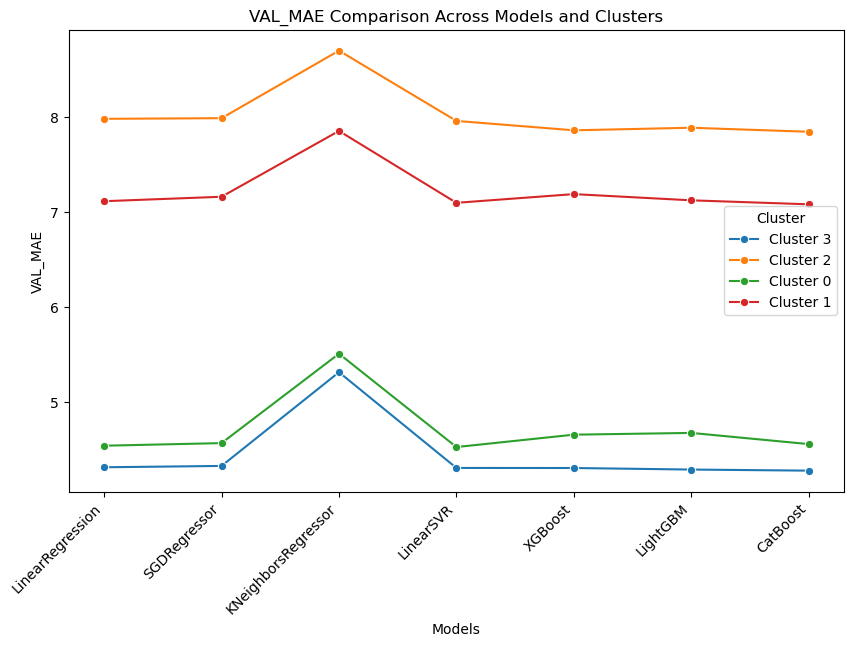

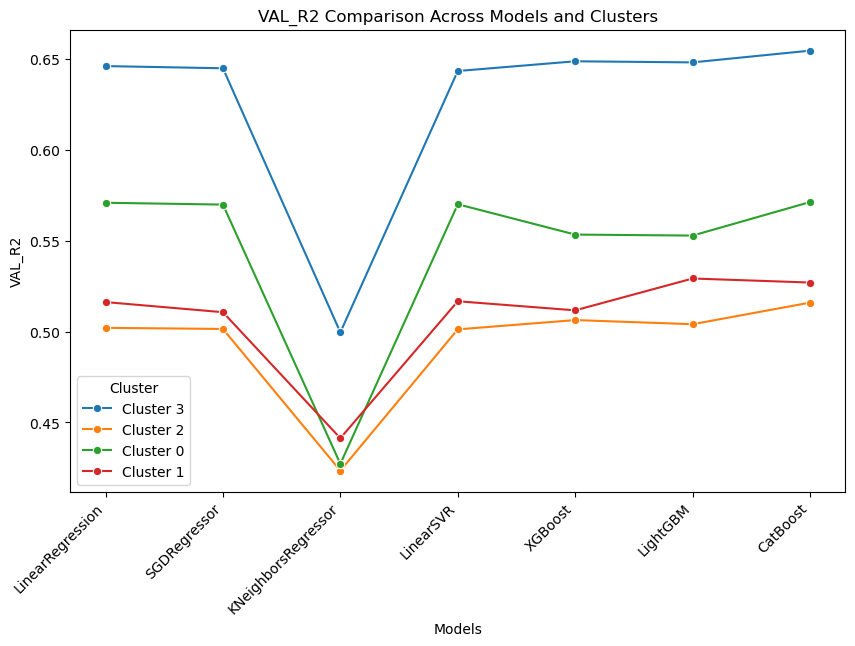

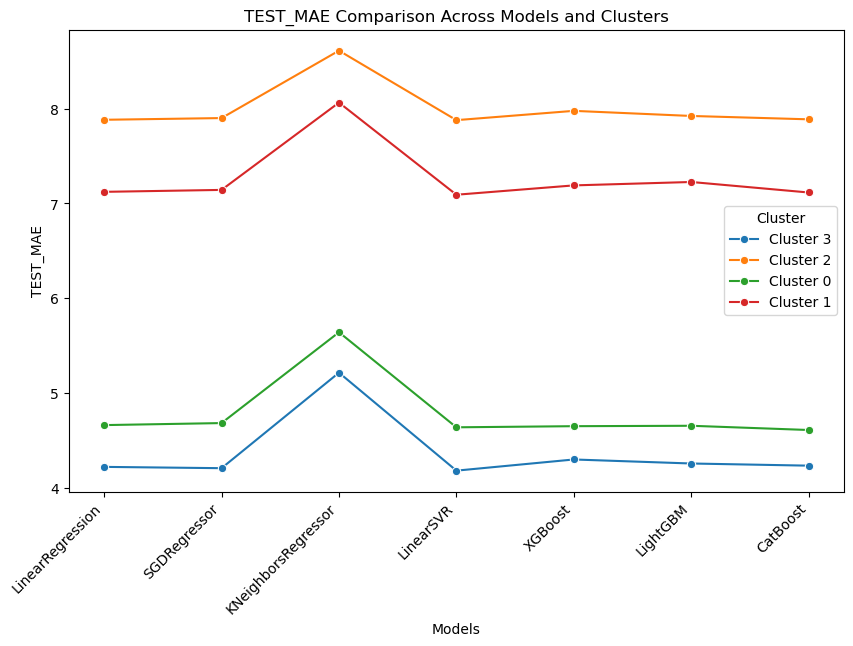

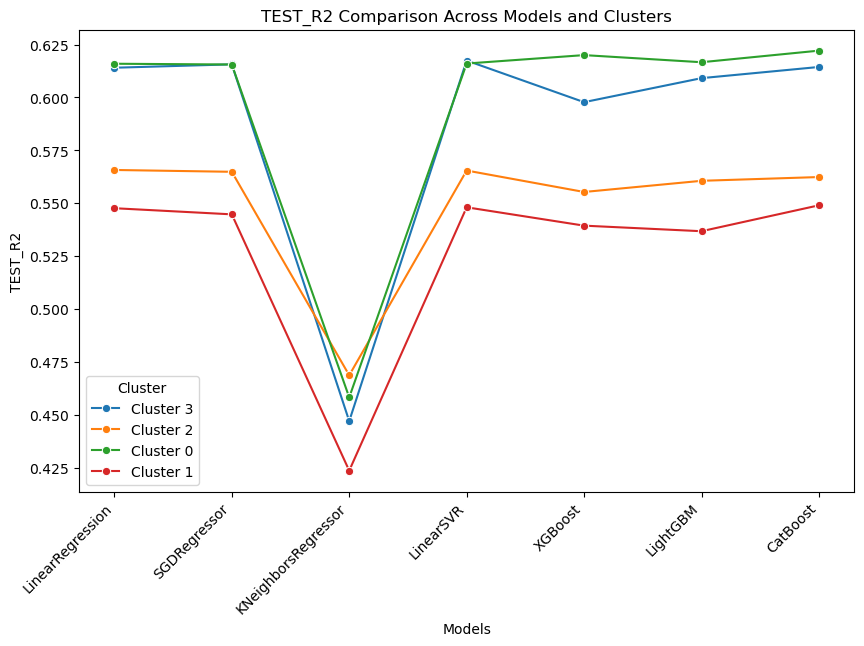

Training and evaluation complete.


In [140]:
# Plotting the metrics
for metric in ['val_mae', 'val_r2', 'test_mae', 'test_r2']:
    plt.figure(figsize=(10, 6))
    for cluster_label in metrics.keys():
        values = [metrics[cluster_label][model][metric] for model in models.keys()]
        sns.lineplot(x=list(models.keys()), y=values, label=f'Cluster {cluster_label}', marker='o')

    plt.title(f'{metric.upper()} Comparison Across Models and Clusters')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel(metric.upper())
    plt.xlabel('Models')
    plt.legend(title='Cluster')
    plt.show()

print("Training and evaluation complete.")

In [142]:
data = []

# Iterate through the metrics dictionary and collect the data
for cluster_label, models_metrics in metrics.items():
    for model_name, scores in models_metrics.items():
        data.append({
            'Cluster': cluster_label,
            'Model': model_name,
            'Validation MAE': scores['val_mae'],
            'Validation R2': scores['val_r2'],
            'Test MAE': scores['test_mae'],
            'Test R2': scores['test_r2']
        })

# Create a DataFrame from the data
df_metrics = pd.DataFrame(data)

# Display the DataFrame in a table format
pd.set_option('display.float_format', lambda x: '%.4f' % x)
print(df_metrics)

# Optionally, display the DataFrame in a Jupyter notebook with a pretty table
import IPython.display as display
display.display(df_metrics)


    Cluster                Model  ...  Test MAE  Test R2
0         3     LinearRegression  ...    4.2178   0.6140
1         3         SGDRegressor  ...    4.2041   0.6156
2         3  KNeighborsRegressor  ...    5.2125   0.4470
3         3            LinearSVR  ...    4.1782   0.6174
4         3              XGBoost  ...    4.2960   0.5978
5         3             LightGBM  ...    4.2536   0.6091
6         3             CatBoost  ...    4.2308   0.6144
7         2     LinearRegression  ...    7.8823   0.5657
8         2         SGDRegressor  ...    7.9003   0.5649
9         2  KNeighborsRegressor  ...    8.6122   0.4687
10        2            LinearSVR  ...    7.8785   0.5655
11        2              XGBoost  ...    7.9766   0.5553
12        2             LightGBM  ...    7.9226   0.5606
13        2             CatBoost  ...    7.8871   0.5624
14        0     LinearRegression  ...    4.6589   0.6159
15        0         SGDRegressor  ...    4.6803   0.6156
16        0  KNeighborsRegresso

,Cluster,Model,Validation MAE,Validation R2,Test MAE,Test R2
0,3,LinearRegression,4.3167,0.6462,4.2178,0.6140
1,3,SGDRegressor,4.3308,0.6450,4.2041,0.6156
2,3,KNeighborsRegressor,5.3163,0.4996,5.2125,0.4470
3,3,LinearSVR,4.3096,0.6435,4.1782,0.6174
4,3,XGBoost,4.3089,0.6489,4.2960,0.5978
5,3,LightGBM,4.2926,0.6482,4.2536,0.6091
6,3,CatBoost,4.2812,0.6547,4.2308,0.6144
7,2,LinearRegression,7.9809,0.5021,7.8823,0.5657
8,2,SGDRegressor,7.9877,0.5015,7.9003,0.5649
9,2,KNeighborsRegressor,8.6980,0.4234,8.6122,0.4687
